In [3]:
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import yfinance as yf
import functions as f
import matplotlib.pyplot as plt
import datetime as dt
import funcoes as f
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
pd.set_option('display.max_rows', 500)

In [4]:
stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date')
# stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date').iloc[ : , :16].drop('BOVA11.SA', axis='columns')
benchmark = stock_prices['BOVA11.SA']
stock_prices.drop('BOVA11.SA', axis=1, inplace=True)

In [17]:
def pipeline(df: pd.DataFrame, training_period: int, oos_period: int, algo: str, show_pesos=False, **kwargs):
    retornos = pd.DataFrame()
    for i, month in enumerate(df.index):
        df = df.dropna(axis='columns')
        if df[(i+training_period+1) : (i+training_period+oos_period+2)].shape[0] > oos_period:
            train_df = df[(i) : (i+training_period+1)].dropna(axis='columns')
            train_df = train_df.pct_change().dropna(axis='rows')
            ## DANGER OF DATA LEAKAGE
            oos_df = df[(i+training_period+1) : (i+training_period+oos_period+2)][train_df.columns]
            oos_df = oos_df.pct_change((oos_period)).dropna() 
            # DANGER OF DATA LEAKAGE
            
            pesos_algo = algo(train_df)
            pesos_df = pd.DataFrame(data={'pesos':pesos_algo}, index=train_df.columns).sort_values(by='pesos', ascending=False).T
    
            
            stock_rets = []  
            retorno_mes = []
            for n, date in enumerate(oos_df.index):
                for stock in oos_df.columns:
                    stock_rets.append(oos_df[stock][n] * pesos_df[stock][n])

                retorno_mes.append(sum(stock_rets))
                retornos[date] = retorno_mes
                
    retornos = retornos.T 
    retornos.rename(columns={0:'rets'}, inplace=True)
    return retornos 

In [14]:
def weight_pca(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
        
    pca = PCA()
    pca_fitted = pca.fit(cov_matrix)
    
    pca_comp = pca_fitted.components_;
    pc_w = pca_comp/ pca_comp.sum()
    
    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normalize to sum to 1
    return res

def weight_eigen(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
    
    D, S = np.linalg.eigh(cov_matrix)
    
    stats = f.summary_stats(pd.DataFrame(S),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = S[:,max_port] / np.sum(S[:,max_port]) # Normalize to sum to 1
    return res

Benchmark Done
EW Done
Eigen Done
PCA Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
EW,0.14291,0.22854,0.62530,0.97542,-0.07182,-0.35372,-0.65041,6.40049,0.10176,0.13092
Eigen,0.17241,0.27074,0.63683,1.08246,-0.07294,-0.38015,-0.44961,5.34981,0.11752,0.14924
PCA,0.16230,0.31274,0.51897,1.13309,-0.08373,-0.37095,0.78649,6.40479,0.10406,0.16434


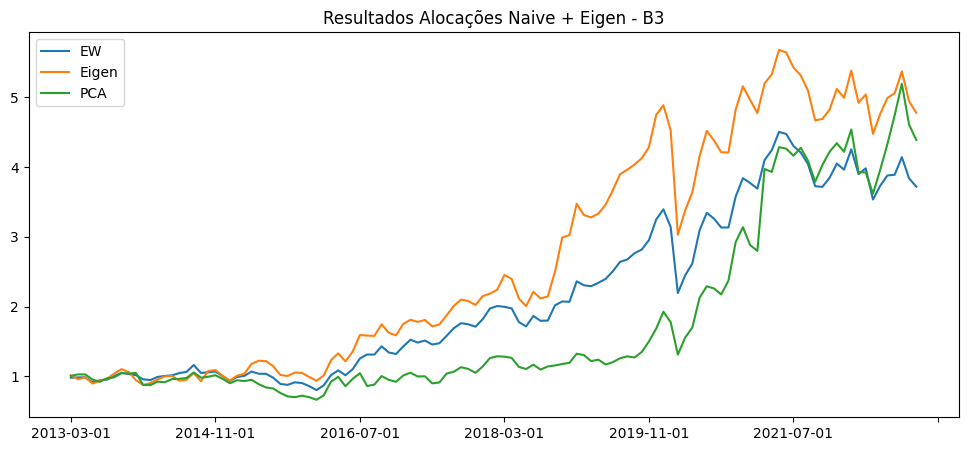

In [20]:
periodos = 12
oos = 1

bova = f.returns(pd.read_csv('precos.csv', sep=';', index_col='Date')['BOVA11.SA']);print('Benchmark Done')
rets_ew = pipeline(stock_prices, periodos, oos, algo=f.weight_ew);print('EW Done')
rets_eigen = pipeline(stock_prices, periodos, oos, algo=weight_eigen);print('Eigen Done')
rets_pca = pipeline(stock_prices, periodos, oos, algo=weight_pca);print('PCA Done')


naive_portfolios_results = pd.DataFrame(
    {
        "BOVA11": bova[rets_ew.index.min():],
        "EW": rets_ew['rets'],
        "Eigen": rets_eigen['rets'],
        "PCA": rets_pca['rets'],
    }
)

(1+naive_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naive + Eigen - B3");
f.summary_stats(naive_portfolios_results, 0)

### LONG-ONLY

In [5]:
def weight_pca_long(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
        
    pca = PCA()
    pca_fitted = pca.fit(cov_matrix)
    
    pca_comp = pca_fitted.components_;
    pc_w = pca_comp
    pc_w[pc_w < 0] = int(0.0001) ## tira os valores negativos, para ser long only

    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normaliza para soma ser igual a 1 (evitar alavangcagem)
    return res

def weight_eigen_long(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
    
    D, pc_w = np.linalg.eigh(cov_matrix)
    pc_w[pc_w < 0] = int(0.0001) ## tira os valores negativos, para ser long only

    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normaliza para soma ser igual a 1 (evitar alavangcagem)
    return res

Benchmark Done
EW Done
Eigen_long Done
PCA_long Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
BOVA11,0.06138,0.23088,0.26583,0.51528,-0.09643,-0.37652,-0.73058,6.24827,0.11067,0.14515
EW,0.14207,0.22759,0.62423,0.96959,-0.07193,-0.35372,-0.64933,6.44925,0.10128,0.13092
Eigen Long,0.15291,0.24714,0.61872,0.98539,-0.07111,-0.37746,-0.60536,6.50881,0.10903,0.13975
PCA Long,0.14099,0.23086,0.61075,1.02468,-0.06908,-0.31997,-0.34816,5.30471,0.09920,0.13603


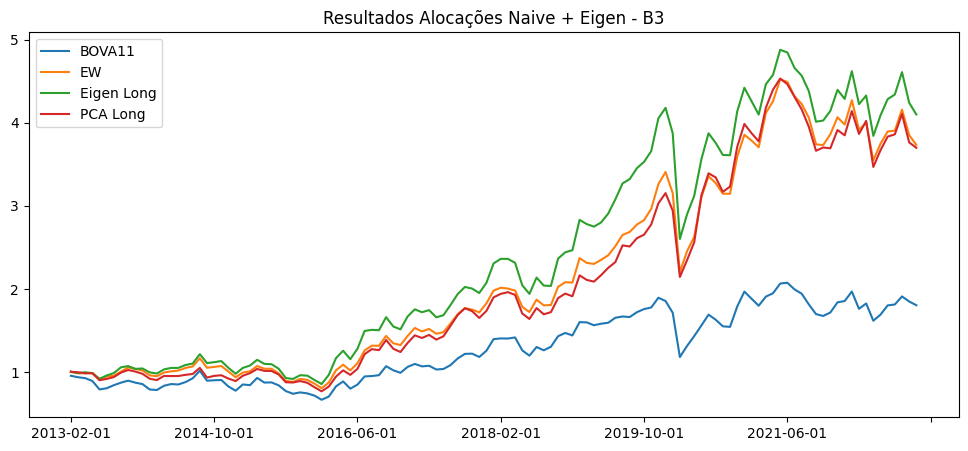

In [6]:
periodos = 12
oos = 1

bova = f.returns(pd.read_csv('precos.csv', sep=';', index_col='Date')['BOVA11.SA']);print('Benchmark Done')
rets_ew = f.pipeline(stock_prices, periodos, oos, algo=f.weight_ew);print('EW Done')
rets_eigen_long = f.pipeline(stock_prices, periodos, oos, algo=weight_eigen_long);print('Eigen_long Done')
rets_pca_long = f.pipeline(stock_prices, periodos, oos, algo=weight_pca_long);print('PCA_long Done')

naive_portfolios_results = pd.DataFrame(
    {
        "BOVA11": bova[rets_ew.index.min():],
        "EW": rets_ew['rets'],
        "Eigen Long": rets_eigen_long['rets'],
        "PCA Long": rets_pca_long['rets'],
    }
)

(1+naive_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naive + Eigen - B3");
f.summary_stats(naive_portfolios_results, 0)